In [11]:
%load_ext autoreload
%autoreload 2

import pygsti
from pygsti.modelpacks import smq1Q_XYI, smq2Q_XYCNOT
import numpy as np
from pprint import pprint
from experiment_helpers import make_depolarized_dataset, run_gst, corrupt_dataset, make_tweaked_dataset, make_tweaked_dataset_pairs
from scipy import linalg as la
import pandas as pd
from pygsti.data.datasetconstruction import mix_datasets
from pygsti.report.plothelpers import rated_n_sigma
from pprint import pprint
from pygsti.tools.optools import fidelity, povm_fidelity, entanglement_fidelity

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
mp = smq1Q_XYI
target = mp.target_model()
fids = (mp.prep_fiducials(), mp.meas_fiducials())
germs = mp.germs()
maxmaxlen = 32
sps = 10_000
dsa, m_dga, dsb, m_dgb = make_tweaked_dataset_pairs(
    mp, depol_level=0.001, rand_unitary_scale=0.03, max_max_len=maxmaxlen,
    sample_error='multinomial', seed=5000009, shots_per_circuit=sps, gaugeopt=False
)

import pygsti.algorithms

mods = []
for model in [m_dga, m_dgb]:
    model = model.copy()
    model.convert_members_inplace('full')
    model.default_gauge_group = 'unitary'
    model = pygsti.algorithms.gaugeopt.gaugeopt_to_target(model, target)
    mods.append(model)

m_dga_gopped, m_dgb_gopped = mods

mixture_weights = np.array([1, 0.95, 0.9, 0.85, 0.8, 0.7, 0.6, 0.575, 0.55, 0.525, 0.51, 0.5, 0.49, 0.475, 0.45, 0.425, 0.4, 0.3, 0.2, 0.15, 0.1, 0.05, 0.0])
num_mixtures = mixture_weights.size
integer_counts_in_mixed = False  # older runs effectively had this == True

fit_mode = 'CPTPLND'
Lpnorm_spec = ('Lp^p', 10)
verb = 1

m_dga.convert_members_inplace(fit_mode)
m_dgb.convert_members_inplace(fit_mode)

In [13]:
reslist = []
for i,p in enumerate(mixture_weights):
    ds = mix_datasets(dsa, dsb, p, integral=integer_counts_in_mixed)
    results = run_gst(ds, fids, germs, target, ['logl', 'normalized tvd', Lpnorm_spec], verbosity=verb, mode=fit_mode)
    reslist.append((results,ds))

--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --



/Users/rjmurr/Documents/pygsti-tvd/pygsti/pygsti/objectivefns/objectivefns.py:4062: UserWarning: This derivative is discontinuous and does not return a full subgradient.
  _warnings.warn('This derivative is discontinuous and does not return a full subgradient.')



--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---


-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --


--- Circuit Creation ---
-- Std Practice:  [##################################################] 100.0%  (CPTPLND) --




In [14]:

dflists = []
for results, dsc in reslist:
    currdfs = []
    for ds in [dsa, dsc, dsb]:
        circuitlist = list(ds.cirIndex.keys())
        pvecs = []
        objectives = []
        Nsigs = []
        for estname, est in results.estimates.items():
            model = est.models['stdgaugeopt']
            try:
                Nsig, _ = rated_n_sigma(ds, model, circuitlist, 'logl')
            except Exception:
                Nsig = np.NaN
            Nsigs.append(Nsig)
            objective = est.final_objective_fn()
            objective.dataset = ds
            objective.add_count_vectors(force=True)
            objective.add_omitted_freqs(force=True)
            objectives.append(objective)
            pvecs.append(est.models['final iteration estimate'].to_vector())
        Nsigs.append(rated_n_sigma(ds, m_dga, circuitlist, 'logl')[0])
        Nsigs.append(rated_n_sigma(ds, m_dgb, circuitlist, 'logl')[0])
        Nsigs = np.array(Nsigs).reshape((-1,1))

        objvals = np.zeros((len(pvecs)+2, len(objectives)))
        for j,objective in enumerate(objectives):
            for i,pvec in enumerate(pvecs):
                val = objective.fn(pvec, stateless=True)
                objvals[i,j] = val
            objvals[i+1,j] = objective.fn_from_model(m_dga)
            objvals[i+2,j] = objective.fn_from_model(m_dgb)
        objvals = np.concatenate((objvals, Nsigs), axis=1)

        df = pd.DataFrame(
            objvals,
            index=['argmin(LogL)', 'argmin(nTVD)', 'argmin(L10^10)', 'Model A', 'Model B'],
            columns=['LogL', 'nTVD', 'L10',  'N_sigma'],
        )
        df.rename_axis(index='model')
        currdfs.append(df)
    dflists.append(currdfs)


In [15]:
dflist = []
for dfl in dflists:
    dfa, df, dfb = dfl
    temp = dfa.join(df, lsuffix='(A)', rsuffix='(mix)')
    dfb = dfb.copy()
    dfb.columns = dfb.columns.map(lambda x: str(x) + '(B)')
    temp = temp.join(dfb)
    temp = temp.sort_index(axis=1)
    for colname in ['L10(A)', 'L10(B)', 'L10(mix)']:
        temp[colname] = temp[colname]**0.1
    dflist.append(temp)

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 300)
for i,df in enumerate(dflist):
    print( '\n' + 250*'-')
    p = mixture_weights[i]
    print(f'\nThe mixture dataset had weight {p:1.2f} on dataset A and weight {1-p:1.2f} on dataset B.\n')
    print(df)
    print()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

The mixture dataset had weight 1.00 on dataset A and weight 0.00 on dataset B.

                  L10(A)    L10(B)  L10(mix)        LogL(A)        LogL(B)      LogL(mix)    N_sigma(A)    N_sigma(B)  N_sigma(mix)     nTVD(A)     nTVD(B)   nTVD(mix)
argmin(LogL)    0.017095  1.143082  0.017095     356.490631  870722.190464     356.490631     -1.031219  44854.838049     -1.031219    3.915744  137.589484    3.915744
argmin(nTVD)    0.017287  1.142589  0.017287     360.248995  870045.936046     360.248995     -0.837525  44819.986056     -0.837525    3.704271  137.461658    3.704271
argmin(L10^10)  0.015880  1.141510  0.015880     548.027542  865450.799571     548.027542      8.839982  44583.167393      8.839982    4.292753  137.443425    4.29

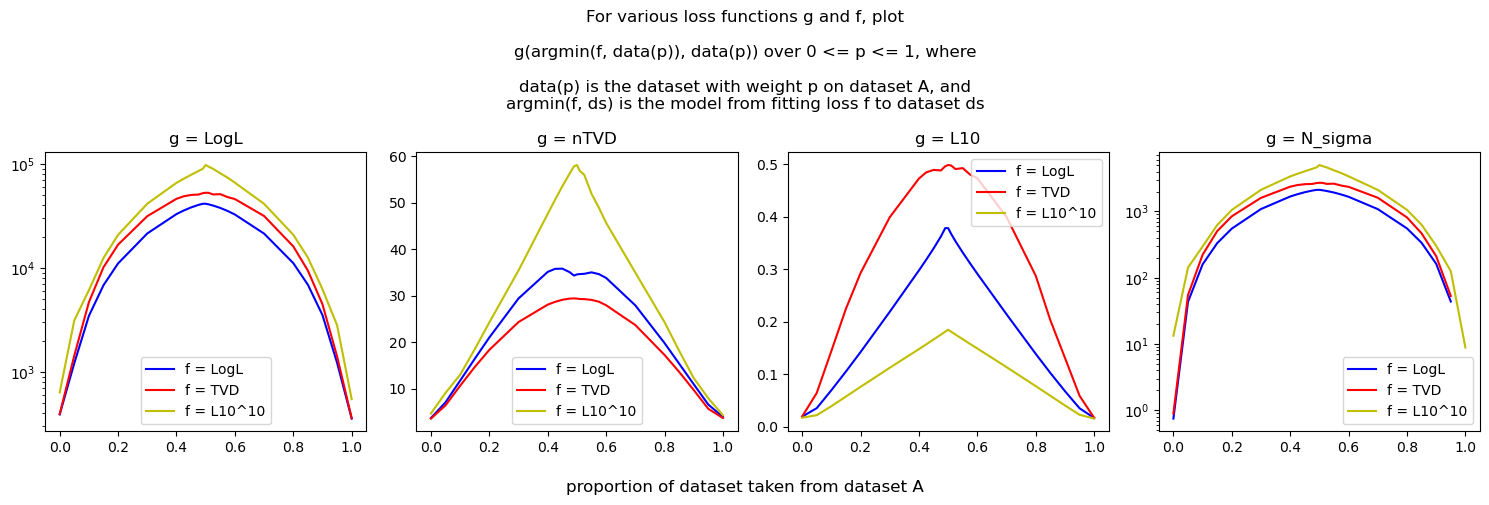

In [16]:
datanames  = [ '(mix)', '(A)', '(B)'] 
modelnames =  ['argmin(LogL)', 'argmin(nTVD)', 'argmin(L10^10)']
legendnames = [ 'f = ' + name.strip('argmin(').strip(')') for name in modelnames ]
lossnames  = ['LogL', 'nTVD', 'L10', 'N_sigma']
losscolors = ['b', 'r', 'y', 'k', 'd','.']
dataname = '(mix)'
fig, outer_axs = plt.subplots(1, len(lossnames), figsize=(15,5))
for metricname,ax in zip(lossnames, outer_axs):
    rows = []
    for df in dflist:
        row = [ df[metricname + dataname][modelname] for modelname in modelnames ]
        rows.append(row)
    y = np.array(rows)
    if metricname in {'LogL', 'chi2', 'N_sigma'}:
        ax.set_yscale('log')
    for i,yi in enumerate(y.T):
        x = mixture_weights
        if metricname in {'LogL', 'chi2', 'N_sigma'}:
            ind = yi > 0
            x   = x[ind]
            yi = yi[ind]
        ax.plot(x, yi,losscolors[i])
    ax.legend(legendnames)
    ax.set_title( 'g = ' + metricname)
fig.suptitle('For various loss functions g and f, plot\n\ng(argmin(f, data(p)), data(p)) over 0 <= p <= 1, where\n\n'
'data(p) is the dataset with weight p on dataset A, and\nargmin(f, ds) is the model from fitting loss f to dataset ds')
fig.supxlabel('proportion of dataset taken from dataset A')
fig.tight_layout()

## View into what models look like
```
rho0
Mdefault = Lindblad-parameterized POVM of length 2
[]       = Exponentiated operation map with dim = 4, num params = 12
Gxpi2:0  = Exponentiated operation map with dim = 4, num params = 12
Gypi2:0  = Exponentiated operation map with dim = 4, num params = 12
```
Could make a 5-by-3 figure, each of 15 panels plotting two measures of fidelity.
 * Top row is SPAM fidelity, bottom row is POVM fidelity, middle rows are gate fidelity.
 * First column is f = LogL, second column is f = nTVD, third column is f = L10^10.
 
The two measures of fidelity are mixed-to-A and mixed-to-B.

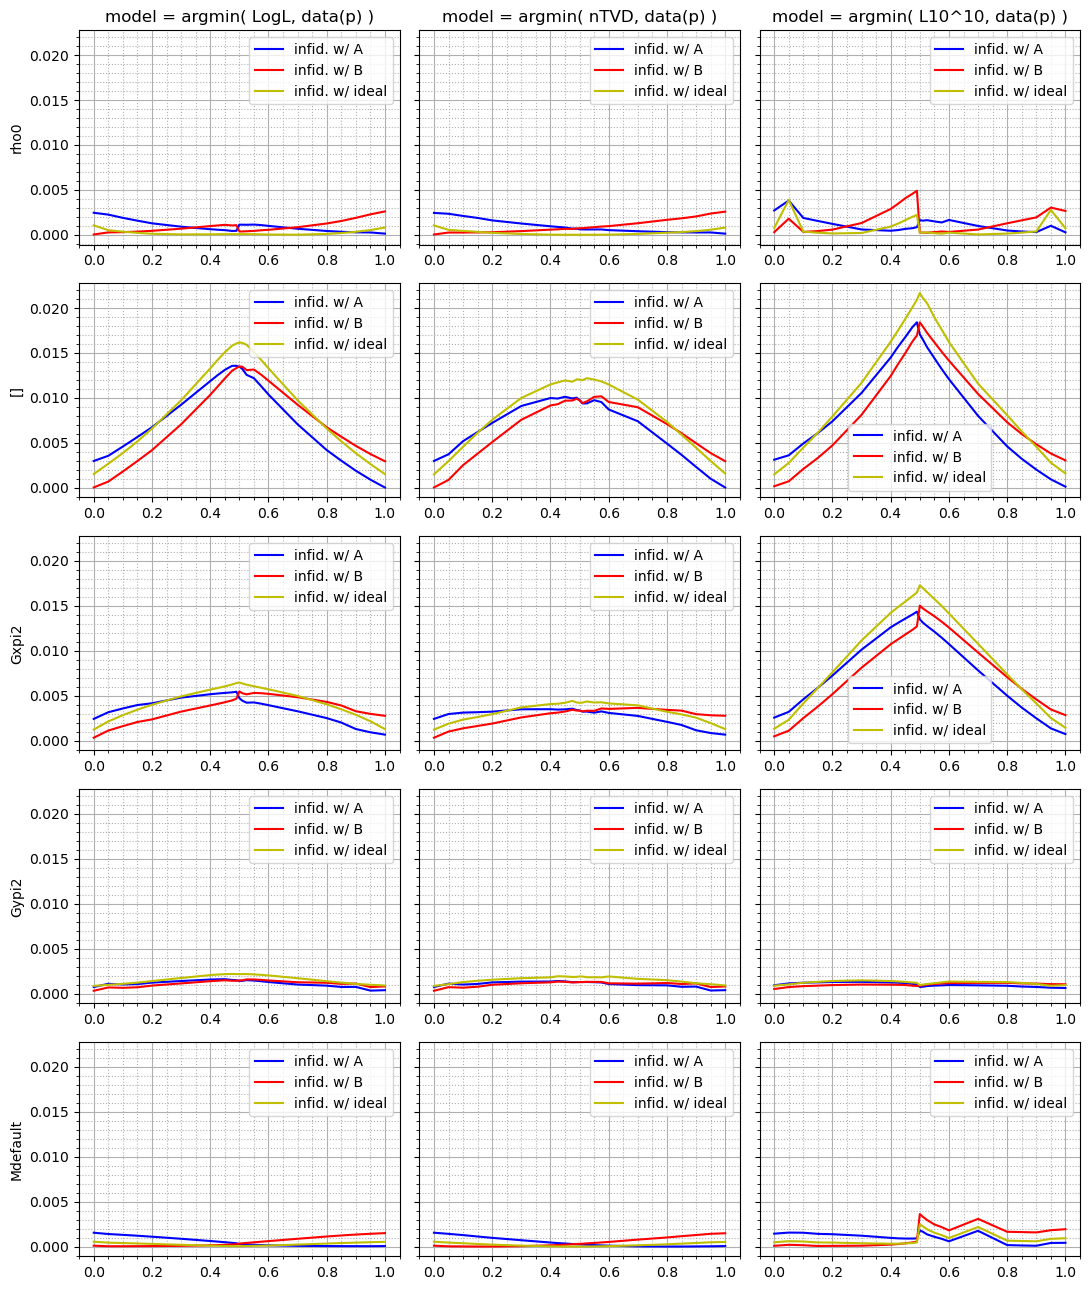

In [26]:
row_lbls = [ str(ell) for ell in m_dga.preps.keys() ] + [ str(ell) for ell in m_dga.operations.keys() ] + [ str(ell) for ell in m_dga.povms.keys() ]
num_rows = len(row_lbls)
modelnames =  ['argmin(LogL)', 'argmin(nTVD)', 'argmin(L10^10)']
modelnames_to_estnames = {'argmin(LogL)': 'logl', 'argmin(nTVD)': 'normalized tvd', 'argmin(L10^10)': "('Lp^p', 10)"}
num_cols   = len(modelnames)
losscolors = ['b', 'r', 'y', 'k', 'd','.']

fig, axs_grid = plt.subplots(num_rows, num_cols, figsize=(2*num_rows + 1, 4*num_cols + 1), sharey='all')

def flexindelity(m1, m2, lbl):
    if 'G' in lbl or lbl == '[]':
        if lbl == '[]':
            lbl = pygsti.baseobjs.Label(())
        else:
            lbl = lbl.split(':')
        mm1 = m1[lbl]
        mm2 = m2[lbl]
        mm1d = mm1.to_dense()
        mm2d = mm2.to_dense()
        return 1 - entanglement_fidelity(mm1d, mm2d)
    elif 'rho' in lbl:
        mm1 = m1[lbl]
        mm2 = m2[lbl]
        mm1d = pygsti.tools.vec_to_stdmx(mm1.to_dense(), 'pp')
        mm2d = pygsti.tools.vec_to_stdmx(mm2.to_dense(), 'pp')
        return 1 - fidelity(mm1d, mm2d)
    elif 'Mdefault' == lbl:
        return 1 - povm_fidelity(m1, m2, lbl)
    else:
        raise ValueError()

for membername, row_axs in zip(row_lbls, axs_grid):
    row_axs[0].set_ylabel(membername.removesuffix(':0')) #, rotation=0)
    for modelname, ax in zip(modelnames, row_axs):
        ftoA_vs_p = np.zeros(num_mixtures)
        ftoB_vs_p = np.zeros(num_mixtures)
        ftoI_vs_p = np.zeros(num_mixtures)
        for i, (res, _) in enumerate(reslist):
            model_argmin = res.estimates[modelnames_to_estnames[modelname]].models['stdgaugeopt']
            ftoA_vs_p[i] = flexindelity(model_argmin, m_dga_gopped, membername)
            ftoB_vs_p[i] = flexindelity(model_argmin, m_dgb_gopped, membername)
            ftoI_vs_p[i] = flexindelity(model_argmin, target, membername)
        ax.plot(mixture_weights, ftoA_vs_p, losscolors[0])
        ax.plot(mixture_weights, ftoB_vs_p, losscolors[1])
        ax.plot(mixture_weights, ftoI_vs_p, losscolors[2])
        modelname = modelname.removeprefix('argmin(').strip(')')
        ax.legend(['infid. w/ A', 'infid. w/ B', 'infid. w/ ideal'])
        ax.minorticks_on()
        ax.grid(linestyle='dotted', which='minor')
        ax.grid(which='major')
        #ax.set_title('f = ' + modelname)
        if membername == 'rho0':
            ax.set_title('model = argmin( %s, data(p) )' % modelname)

fig.set_tight_layout(True)


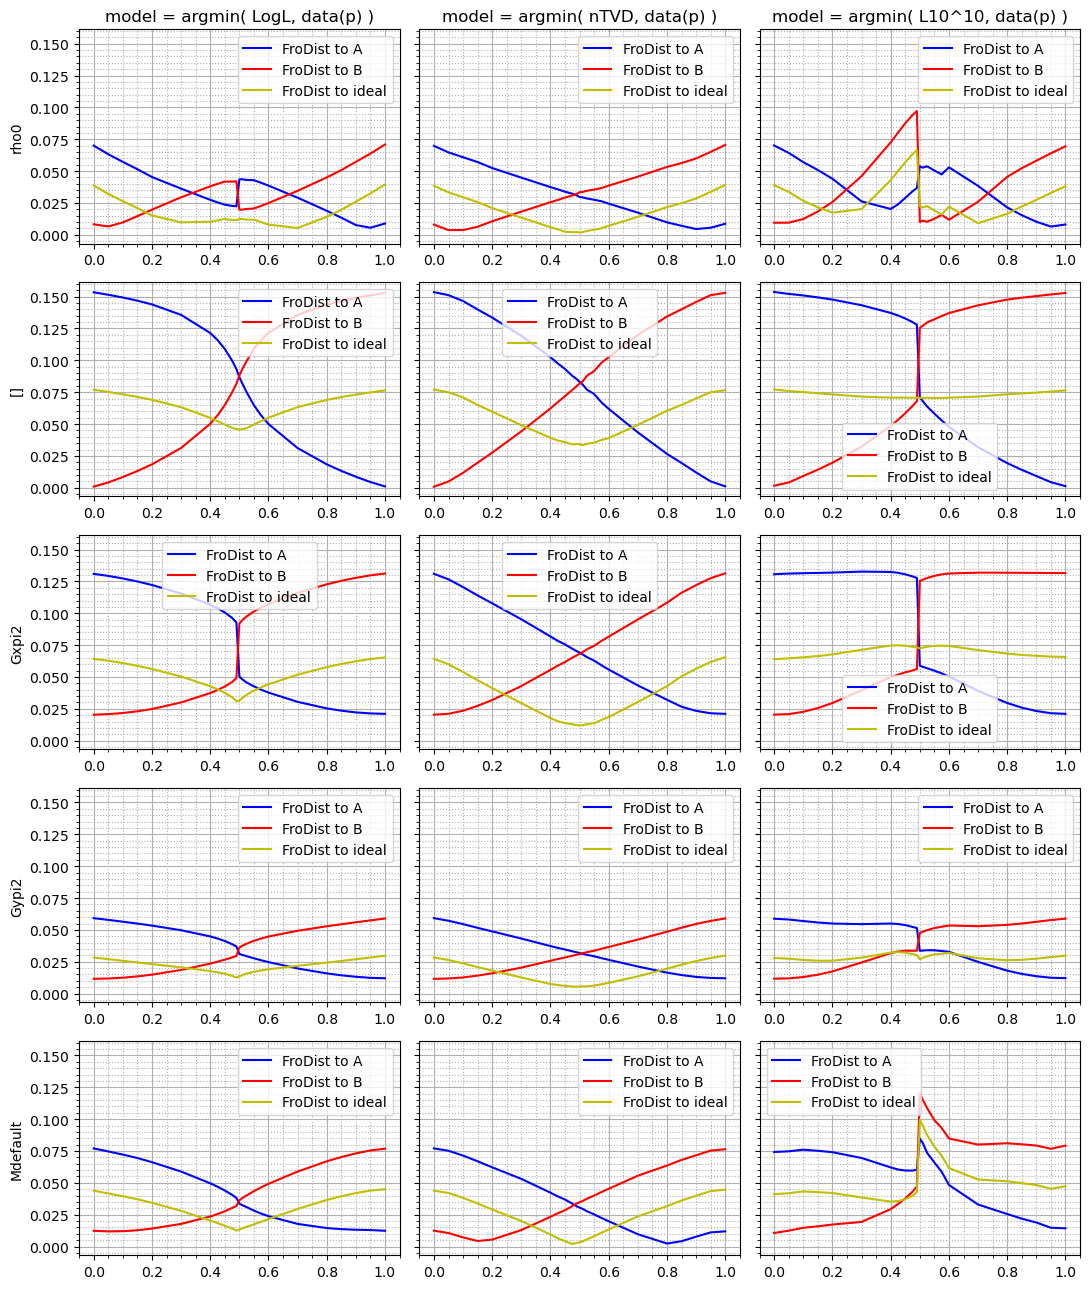

In [27]:
fig, axs_grid = plt.subplots(num_rows, num_cols, figsize=(2*num_rows + 1, 4*num_cols + 1), sharey='all')

def flexibeniusnorm(m1, m2, lbl):
    if 'G' in lbl or lbl == '[]':
        if lbl == '[]':
            lbl = pygsti.baseobjs.Label(())
        else:
            lbl = lbl.split(':')
        mm1 = m1[lbl]
        mm2 = m2[lbl]
        mm1d = mm1.to_dense()
        mm2d = mm2.to_dense()
        return la.norm(mm1d - mm2d)
    elif 'rho' in lbl:
        mm1 = m1[lbl]
        mm2 = m2[lbl]
        mm1d = pygsti.tools.vec_to_stdmx(mm1.to_dense(), 'pp')
        mm2d = pygsti.tools.vec_to_stdmx(mm2.to_dense(), 'pp')
        return la.norm(mm1d - mm2d)
    elif 'Mdefault' == lbl:
        mm1d = np.array([e.to_dense() for e in m1[lbl].values()])
        mm2d = np.array([e.to_dense() for e in m2[lbl].values()])
        return la.norm(mm1d - mm2d)
    else:
        raise ValueError()

for membername, row_axs in zip(row_lbls, axs_grid):
    row_axs[0].set_ylabel(membername.removesuffix(':0')) #, rotation=0)
    for modelname, ax in zip(modelnames, row_axs):
        ftoA_vs_p = np.zeros(num_mixtures)
        ftoB_vs_p = np.zeros(num_mixtures)
        ftoI_vs_p = np.zeros(num_mixtures)
        # ax.set_title(modelname)
        for i, (res, _) in enumerate(reslist):
            model_argmin = res.estimates[modelnames_to_estnames[modelname]].models['stdgaugeopt']
            ftoA_vs_p[i] = flexibeniusnorm(model_argmin, m_dga_gopped, membername)
            ftoB_vs_p[i] = flexibeniusnorm(model_argmin, m_dgb_gopped, membername)
            ftoI_vs_p[i] = flexibeniusnorm(model_argmin, target, membername)
        ax.plot(mixture_weights, ftoA_vs_p, losscolors[0])
        ax.plot(mixture_weights, ftoB_vs_p, losscolors[1])
        ax.plot(mixture_weights, ftoI_vs_p, losscolors[2])
        modelname = modelname.removeprefix('argmin(').strip(')')
        ax.legend(['FroDist to A', 'FroDist to B', 'FroDist to ideal'])
        ax.minorticks_on()
        ax.grid(linestyle='dotted', which='minor')
        ax.grid(which='major')
        if membername == 'rho0':
            ax.set_title('model = argmin( %s, data(p) )' % modelname)

fig.set_tight_layout(True)

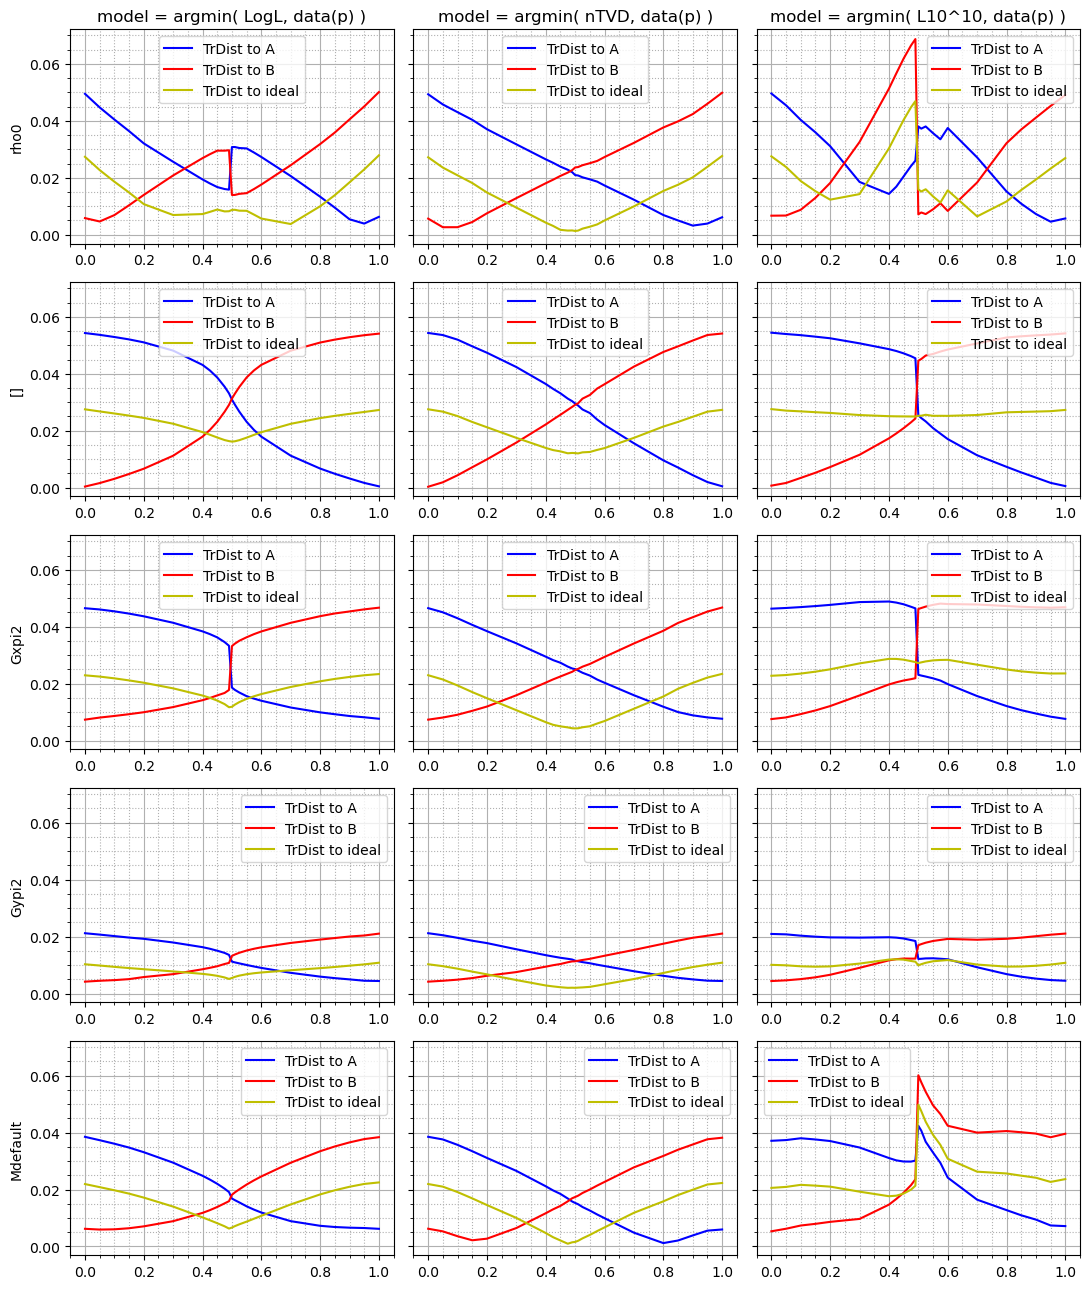

In [29]:
fig, axs_grid = plt.subplots(num_rows, num_cols, figsize=(2*num_rows + 1, 4*num_cols + 1), sharey='all')

def flexitracenorm(m1, m2, lbl):
    if 'G' in lbl or lbl == '[]':
        if lbl == '[]':
            lbl = pygsti.baseobjs.Label(())
        else:
            lbl = lbl.split(':')
        mm1 = m1[lbl]
        mm2 = m2[lbl]
        mm1d = mm1.to_dense()
        mm2d = mm2.to_dense()
        return pygsti.tools.optools.jtracedist(mm1d, mm2d, 'pp')
    elif 'rho' in lbl:
        mm1 = m1[lbl]
        mm2 = m2[lbl]
        mm1d = pygsti.tools.vec_to_stdmx(mm1.to_dense(), 'pp')
        mm2d = pygsti.tools.vec_to_stdmx(mm2.to_dense(), 'pp')
        return pygsti.tools.optools.tracedist(mm1d, mm2d)
    elif 'Mdefault' == lbl:
        mm1d = np.array([e.to_dense() for e in m1[lbl].values()])
        mm2d = np.array([e.to_dense() for e in m2[lbl].values()])
        return pygsti.tools.optools.povm_jtracedist(m1, m2, lbl)
    else:
        raise ValueError()

for membername, row_axs in zip(row_lbls, axs_grid):
    row_axs[0].set_ylabel(membername.removesuffix(':0')) #, rotation=0)
    for modelname, ax in zip(modelnames, row_axs):
        ftoA_vs_p = np.zeros(num_mixtures)
        ftoB_vs_p = np.zeros(num_mixtures)
        ftoI_vs_p = np.zeros(num_mixtures)
        for i, (res, _) in enumerate(reslist):
            model_argmin = res.estimates[modelnames_to_estnames[modelname]].models['stdgaugeopt']
            ftoA_vs_p[i] = flexitracenorm(model_argmin, m_dga_gopped, membername)
            ftoB_vs_p[i] = flexitracenorm(model_argmin, m_dgb_gopped, membername)
            ftoI_vs_p[i] = flexitracenorm(model_argmin, target, membername)
        ax.plot(mixture_weights, ftoA_vs_p, losscolors[0])
        ax.plot(mixture_weights, ftoB_vs_p, losscolors[1])
        ax.plot(mixture_weights, ftoI_vs_p, losscolors[2])
        modelname = modelname.removeprefix('argmin(').strip(')')
        ax.legend(['TrDist to A', 'TrDist to B', 'TrDist to ideal'])
        ax.minorticks_on()
        ax.grid(linestyle='dotted', which='minor')
        ax.grid(which='major')
        #ax.set_title('f = ' + modelname)
        if membername == 'rho0':
            ax.set_title('model = argmin( %s, data(p) )' % modelname)
fig.set_tight_layout(True)

In [20]:
print(m_dga.operations.keys())
print([str(ell) for ell in m_dga.operations.keys()])
print(m_dga.preps.keys())
print(m_dga.povms.keys())
print(m_dga['Mdefault'])
print(results.estimates)
print(len(reslist))
print(num_mixtures)

odict_keys([Label(()), Label(('Gxpi2', 0)), Label(('Gypi2', 0))])
['[]', 'Gxpi2:0', 'Gypi2:0']
odict_keys([Label('rho0')])
odict_keys([Label('Mdefault')])
Lindblad-parameterized POVM of length 2

OrderedDict([('logl', <pygsti.protocols.estimate.Estimate object at 0x32fca6490>), ('normalized tvd', <pygsti.protocols.estimate.Estimate object at 0x3320e8050>), ("('Lp^p', 10)", <pygsti.protocols.estimate.Estimate object at 0x332310050>)])
23
23
